Dataset link
https://drive.google.com/file/d/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp/view

Annotations link
https://drive.google.com/file/d/175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m/view

In [ ]:
# the command : gdown https://drive.google.com/uc?id=file_id

In [ ]:
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp

Downloading...
From: https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
To: /content/101_ObjectCategories.tar.gz
132MB [00:01, 80.7MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m

Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/Annotations.tar
14.0MB [00:00, 65.6MB/s]


In [ ]:
!tar -xzf 101_ObjectCategories.tar.gz && cp -r 101_ObjectCategories/airplanes . && tar -xf Annotations.tar && cp -r Annotations/Airplanes_Side_2/ .

In [ ]:
!rm -rf 101_ObjectCategories Annotations

In [ ]:
# Code to obtain required csv file

!touch airplanes.csv

import os
import scipy.io
import pandas as pd

air = open('airplanes.csv', 'w')

for f in os.listdir('Airplanes_Side_2'):
  st = f"image{f[10:-4]}.jpg"
  mat = scipy.io.loadmat('Airplanes_Side_2/' + f)
  mat = {k:v for k, v in mat.items() if k[0] != '_'}
  data = pd.DataFrame({k: pd.Series(v[0]) for k, v in mat.items()}) # compatible for both python 2.x and python 3.x

  coord = data['box_coord'].to_numpy()
  st = f"{st},{int(coord[2])},{int(coord[0])},{int(coord[3])},{int(coord[1])}"
  print(st, file=air)
  # data.to_csv(f[:-3] + "csv")


In [ ]:
IMAGES_PATH = "airplanes"
ANNOTS_PATH = "airplanes.csv"

In [ ]:
BASE_OUTPUT = "output"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot,png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [ ]:
!mkdir output

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2

rows = open(ANNOTS_PATH).read().strip().split("\n")
data = []
targets = []
filenames = []

for row in rows:
  row = row.split(",")
  (filename, startX, startY, endX, endY) = row
  imagePath = os.path.sep.join([IMAGES_PATH, filename])
  image = cv2.imread(imagePath)
  (h, w) = image.shape[:2]

  startX = float(startX)/w
  startY = float(startY)/h
  endX = float(endX)/w
  endY = float(endY)/h

  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)

  data.append(image)
  targets.append([startX, startY, endX, endY])
  filenames.append(filename)

data = np.array(data, dtype="float32")/255.0
targets = np.array(targets, dtype="float32")

split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
hist = model.fit(
    trainImages, trainTargets,
    validation_data = (testImages, testTargets),
    batch_size = BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
)

Epoch 1/25
16/16 [==============================] - 63s 1s/step - loss: 0.0249 - val_loss: 0.0029
Epoch 2/25
16/16 [==============================] - 4s 275ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/25
16/16 [==============================] - 4s 273ms/step - loss: 0.0012 - val_loss: 7.4080e-04
Epoch 4/25
16/16 [==============================] - 4s 274ms/step - loss: 8.2794e-04 - val_loss: 5.9485e-04
Epoch 5/25
16/16 [==============================] - 4s 273ms/step - loss: 6.7604e-04 - val_loss: 5.3523e-04
Epoch 6/25
16/16 [==============================] - 4s 272ms/step - loss: 5.8066e-04 - val_loss: 5.0714e-04
Epoch 7/25
16/16 [==============================] - 4s 274ms/step - loss: 5.1101e-04 - val_loss: 4.9486e-04
Epoch 8/25
16/16 [==============================] - 4s 275ms/step - loss: 4.5236e-04 - val_loss: 4.9225e-04
Epoch 9/25
16/16 [==============================] - 4s 273ms/step - loss: 4.1410e-04 - val_loss: 5.1830e-04
Epoch 10/25
16/16 [==============================]

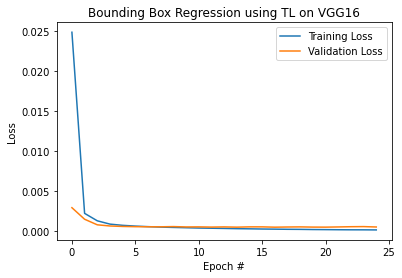

In [ ]:
model.save(MODEL_PATH, save_format="h5")

plt.figure()
plt.plot(hist.history['loss'], label="Training Loss")
plt.plot(hist.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.title("Bounding Box Regression using TL on VGG16")
plt.legend()
plt.savefig(PLOT_PATH)

### Predictor follows

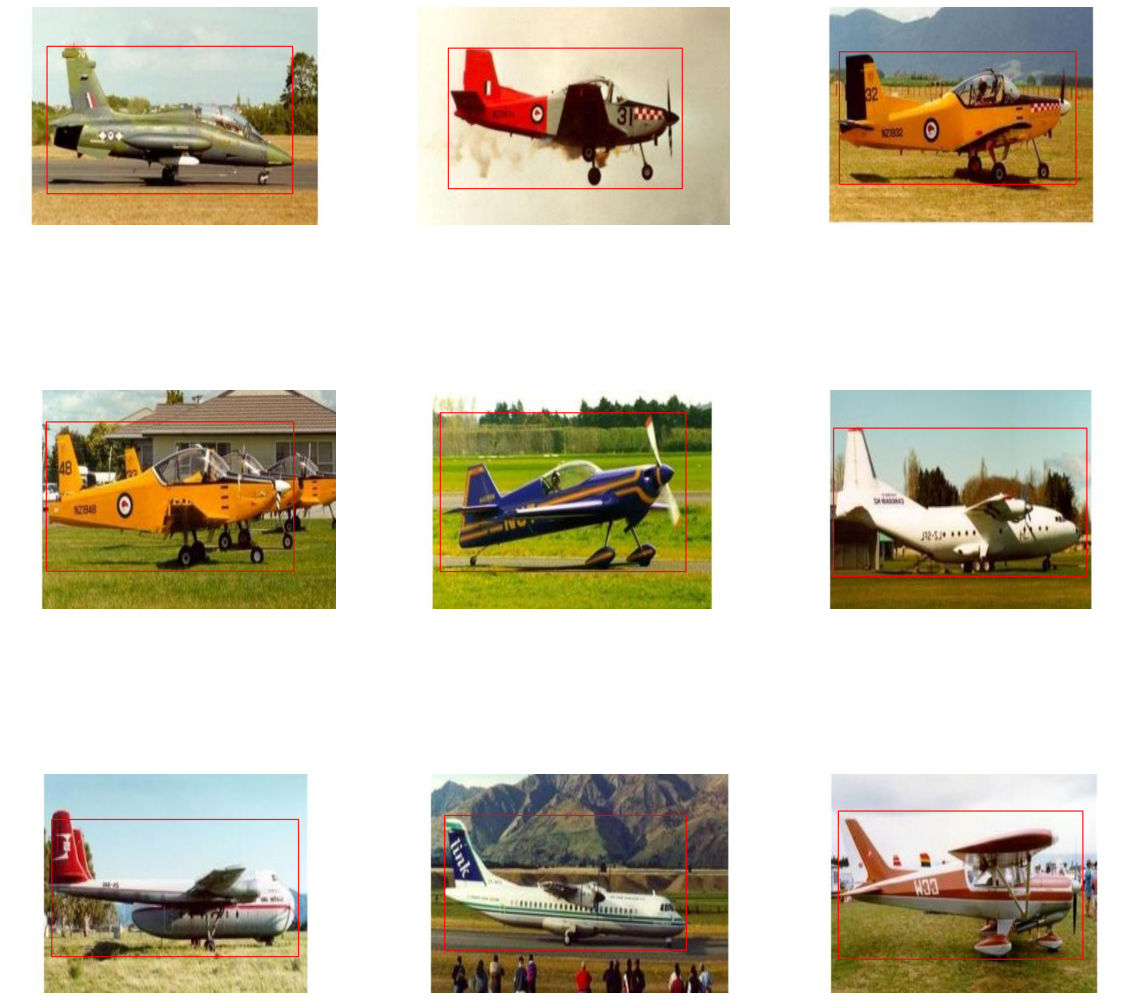

In [ ]:
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow

predictor = load_model(MODEL_PATH)

plt.figure(figsize=(20, 20))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  img = load_img(f'airplanes/image_000{i+1}.jpg', target_size=(224, 224))
  img = img_to_array(img)/255.0
  img = np.expand_dims(img, axis=0)
  preds = predictor.predict(img)[0]
  (startX, startY, endX, endY) = preds

  img = cv2.imread(f'airplanes/image_000{i+1}.jpg')
  img = cv2.resize(img, (900, 600))

  (h, w) = img.shape[:2]

  startX = int(startX*w)
  startY = int(startY*h)
  endX = int(endX*w)
  endY = int(endY*h)

  cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  # cv2_imshow(img)
  plt.imshow(img)
  plt.axis("off")